# RNN-LSTM model to predict the return value of cryptocurrency
## Final Project

Svein Gonzalez, Collin Chee, Raymond Tang, Dipika Kumar

MIDS w207 Section 1
Instructor: Cornelia Ilin



#### ``Objectives``

1. Build a RNN-LSTM model for time series <span style="color:chocolate">Crypto Currency Forecasting</span> 
2. Predict 15 minute residualized returns (Target) from timestamp, Asset_ID, Count, Open, High, Low, Close, Volume, VWAP (Features)
3. Use <span style="color:chocolate">RNN/LSTM</span> to model crypto time series based on 1-hour(60-minutes) timesteps
4. Dateset is obtained from Kaggle's G-Research Crypto Forecasting here:
   https://www.kaggle.com/competitions/g-research-crypto-forecasting/data

In [1]:
#data manipulation
import pandas as pd
import numpy as np
import os

# analysis
import patsy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Masking
tf.keras.backend.set_floatx('float64')

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

from datetime import datetime
from datetime import timedelta

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

# set the max columns to none
pd.set_option('display.max_columns', None)

2023-04-15 23:04:25.480638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-15 23:04:27.498676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:27.503599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:27.504491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-04-15 23:04:27.519786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:27.520766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:27.521634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6



2023-04-15 23:04:28.031035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:28.032018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:04:28.032769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
!pwd

/workspace/W207_Final_Project/g-research-crypto-forecasting


In [6]:
if os.path.isdir("dataset") == False:
    !kaggle competitions download -c g-research-crypto-forecasting

In [7]:
crypto_df = pd.read_csv('dataset/train.csv')
crypto_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [8]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
crypto_df.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,24236806.0000,24236806.0000,24236806.0000,24236806.0000,24236806.0000,24236806.0000,24236806.0000,24236806.0000,24236797.0000,23486468.0000
mean,1577120425.3125,6.2925,286.4593,1432.6405,1436.3504,1429.5676,1432.6400,286852.9856,NaN,0.0000
std,33233501.7421,4.0919,867.3982,6029.6050,6039.4824,6020.2607,6029.6106,2433934.6459,NaN,0.0057
min,1514764860.0000,0.0000,1.0000,0.0012,0.0012,0.0002,0.0012,-0.3663,-inf,-0.5094
25%,1549011480.0000,3.0000,19.0000,0.2676,0.2682,0.2669,0.2676,141.0725,0.2676,-0.0017
50%,1578371880.0000,6.0000,64.0000,14.2886,14.3125,14.2630,14.2892,1295.4146,14.2877,-0.0000
75%,1606197540.0000,9.0000,221.0000,228.8743,229.3000,228.4200,228.8729,27297.6401,228.8728,0.0016
max,1632182400.0000,13.0000,165016.0000,64805.9438,64900.0000,64670.5300,64808.5373,759755403.1424,inf,0.9642


In [9]:
asset_details = pd.read_csv("dataset/asset_details.csv")
asset_details = asset_details.sort_values("Asset_ID")
asset_details = asset_details.reset_index(drop = True)
asset_details

,Asset_ID,Weight,Asset_Name
0,0,4.3041,Binance Coin
1,1,6.7799,Bitcoin
2,2,2.3979,Bitcoin Cash
3,3,4.4067,Cardano
4,4,3.5553,Dogecoin
5,5,1.3863,EOS.IO
6,6,5.8944,Ethereum
7,7,2.0794,Ethereum Classic
8,8,1.0986,IOTA
9,9,2.3979,Litecoin


## Remove NaN and INF

In [10]:
# Replace infinite updated data with nan
crypto_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop rows with NaN
crypto_df.dropna(inplace=True)

# drop rows with negative volume 
crypto_df=crypto_df[crypto_df.Volume>0]

# reset index
crypto_df.reset_index(
    drop=True,
    inplace=True
)


In [11]:
# look at summary again
crypto_df.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000,23486457.0000
mean,1577541313.6106,6.2243,295.4029,1476.0508,1479.8768,1472.8822,1476.0503,294731.7511,1476.0387,0.0000
std,33333675.5777,4.0995,879.6245,6119.9517,6129.9670,6110.4736,6119.9574,2471421.1639,6119.9040,0.0057
min,1514764860.0000,0.0000,1.0000,0.0012,0.0012,0.0002,0.0012,0.0000,-799.7471,-0.5094
25%,1549306260.0000,3.0000,22.0000,0.2809,0.2819,0.2800,0.2809,149.3899,0.2809,-0.0017
50%,1578971040.0000,6.0000,69.0000,14.8684,14.8900,14.8440,14.8686,1332.3629,14.8672,-0.0000
75%,1606979460.0000,9.0000,231.0000,234.9650,235.3800,234.5200,234.9686,29115.1704,234.9650,0.0016
max,1632181440.0000,13.0000,165016.0000,64805.9438,64900.0000,64670.5300,64808.5373,759755403.1424,64799.8222,0.9642


In [12]:
crypto_df.shape

(23486457, 10)

In [13]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486457 entries, 0 to 23486456
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.7 GB


## Add real asset name and convert Timestamp into readable format

In [14]:
def crypto_df_maker(my_df, asset_id=-1):
    '''
    This will subset the original data frame to only show one type of cryptocurrency
    asset_id: Type of crypto currency id from the asset_details table
    If asset_is==-1, it includes all crypto currencies
    '''
    
    if (asset_id == -1):
        df = my_df
    else:
        df = my_df[my_df['Asset_ID'] == asset_id] #based on asset_id filter crypto_df
        df = df.reset_index(drop = True)
    
    df['timestamp'] =  pd.to_datetime(df['timestamp'], unit='s') #change timestamp to a date + time
    df = pd.merge(df, asset_details[["Asset_ID", "Asset_Name"]], on="Asset_ID", how="left") #add the name to the df
    
    temp_cols=df.columns.tolist() #move asset_name to the 2 index
    new_cols= temp_cols[:2] + temp_cols[-1:] + temp_cols[2:-1]
    df=df[new_cols]
    
    return df

In [15]:
#crypto_df = crypto_df_maker(crypto_df, asset_id=1)
crypto_df = crypto_df_maker(crypto_df)
crypto_df.head()

,timestamp,Asset_ID,Asset_Name,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2018-01-01 00:01:00,2,Bitcoin Cash,40.0000,2376.5800,2399.5000,2357.1400,2374.5900,19.2330,2373.1164,-0.0042
1,2018-01-01 00:01:00,0,Binance Coin,5.0000,8.5300,8.5300,8.5300,8.5300,78.3800,8.5300,-0.0144
2,2018-01-01 00:01:00,1,Bitcoin,229.0000,13835.1940,14013.8000,13666.1100,13850.1760,31.5501,13827.0621,-0.0146
3,2018-01-01 00:01:00,5,EOS.IO,32.0000,7.6596,7.6596,7.6567,7.6576,6626.7134,7.6577,-0.0139
4,2018-01-01 00:01:00,7,Ethereum Classic,5.0000,25.9200,25.9200,25.8740,25.8770,121.0873,25.8914,-0.0083


## Shrink dataset to smaller size since RNN-LSTM model run slow with large data size

In [16]:
crypto_df = crypto_df[(crypto_df['timestamp'] >= '2020-10-01') & (crypto_df['timestamp'] < '2020-11-01')]

In [17]:
crypto_df.shape

(596088, 11)

## Sort dataset based on timestamp

In [18]:
crypto_df.sort_values(by=['timestamp'], inplace=True)

In [19]:
crypto_df.head(10)

,timestamp,Asset_ID,Asset_Name,Count,Open,High,Low,Close,Volume,VWAP,Target
16382768,2020-10-01 00:01:00,3,Cardano,101.0000,0.1014,0.1015,0.1013,0.1014,275978.1361,0.1015,0.0029
16382780,2020-10-01 00:01:00,11,Monero,35.0000,108.6350,108.8100,108.4600,108.7175,59.4327,108.7008,-0.0008
16382779,2020-10-01 00:01:00,12,Stellar,151.0000,0.0750,0.0751,0.0749,0.0751,258970.1328,0.0750,-0.0033
16382778,2020-10-01 00:01:00,13,TRON,82.0000,0.0262,0.0263,0.0262,0.0262,1511164.7801,0.0262,-0.0007
16382776,2020-10-01 00:01:00,9,Litecoin,74.0000,46.2968,46.3500,46.2700,46.3092,1101.5174,46.3107,-0.0001
16382775,2020-10-01 00:01:00,6,Ethereum,685.0000,360.3317,361.0500,360.0000,360.5800,1999.4757,360.5409,-0.0005
16382777,2020-10-01 00:01:00,10,Maker,19.0000,571.5202,572.0600,570.8265,571.7000,3.5801,571.5715,-0.0084
16382773,2020-10-01 00:01:00,5,EOS.IO,109.0000,2.5793,2.5818,2.5785,2.5803,12548.6713,2.5800,-0.0002
16382772,2020-10-01 00:01:00,4,Dogecoin,25.0000,0.0026,0.0026,0.0026,0.0026,786045.6700,0.0026,-0.0004
16382771,2020-10-01 00:01:00,1,Bitcoin,2468.0000,10784.2086,10819.0000,10778.9000,10799.1243,289.1827,10793.9181,0.0009


In [20]:
crypto_df.tail(10)

,timestamp,Asset_ID,Asset_Name,Count,Open,High,Low,Close,Volume,VWAP,Target
16978849,2020-10-31 23:59:00,6,Ethereum,168.0000,386.7150,387.0000,386.3500,386.5600,413.1228,386.6522,0.0037
16978848,2020-10-31 23:59:00,7,Ethereum Classic,11.0000,5.2694,5.2750,5.2618,5.2705,301.1394,5.2697,0.0005
16978845,2020-10-31 23:59:00,1,Bitcoin,671.0000,13799.8065,13816.0800,13787.0000,13797.3333,49.9326,13800.2610,0.0020
16978846,2020-10-31 23:59:00,4,Dogecoin,3.0000,0.0026,0.0026,0.0026,0.0026,10050.6800,0.0026,0.0054
16978844,2020-10-31 23:59:00,0,Binance Coin,436.0000,28.4929,28.5375,28.4910,28.5033,5938.9255,28.5059,-0.0053
16978843,2020-10-31 23:59:00,2,Bitcoin Cash,29.0000,262.1650,262.3500,262.0300,262.1450,31.5002,262.1631,-0.0015
16978842,2020-10-31 23:59:00,3,Cardano,6.0000,0.0930,0.0930,0.0929,0.0930,1384.4982,0.0930,-0.0001
16978854,2020-10-31 23:59:00,12,Stellar,19.0000,0.0778,0.0778,0.0777,0.0778,11953.4901,0.0777,0.0010
16978847,2020-10-31 23:59:00,5,EOS.IO,52.0000,2.5286,2.5290,2.5278,2.5282,1815.8840,2.5284,0.0003
16978855,2020-10-31 23:59:00,11,Monero,18.0000,126.5200,126.5300,126.4700,126.5200,17.2470,126.5047,0.0074


## Data Transformation

### Convert High, Low, Open, Close, and Volume into Growth in Price per Volume (GPV) and Change in Price per Volume (CPV)

In [21]:
crypto_df['GinP'] = crypto_df.Close - crypto_df.Open

In [22]:
crypto_df['CinP'] = crypto_df.High - crypto_df.Low

In [23]:
crypto_df.head(2)

,timestamp,Asset_ID,Asset_Name,Count,Open,High,Low,Close,Volume,VWAP,Target,GinP,CinP
16382768,2020-10-01 00:01:00,3,Cardano,101.0000,0.1014,0.1015,0.1013,0.1014,275978.1361,0.1015,0.0029,0.0001,0.0002
16382780,2020-10-01 00:01:00,11,Monero,35.0000,108.6350,108.8100,108.4600,108.7175,59.4327,108.7008,-0.0008,0.0825,0.3500


In [24]:
variables = ['Target', 'timestamp', 'Asset_ID', 'GinP', 'CinP', 'Count', 'Volume', 'VWAP', ]

In [25]:
# this is our baseline model with transformed variables 
crypto_base_model_df = crypto_df[variables]

In [26]:
crypto_base_model_df.describe()

,Target,timestamp,Asset_ID,GinP,CinP,Count,Volume,VWAP
count,596088.0000,596088,596088.0000,596088.0000,596088.0000,596088.0000,596088.0000,596088.0000
mean,0.0000,2020-10-16 11:58:56.199621376,6.4356,0.0037,2.1598,150.2942,216746.1911,990.4915
min,-0.1282,2020-10-01 00:01:00,0.0000,-168.7130,0.0000,1.0000,0.0000,0.0025
25%,-0.0014,2020-10-08 17:42:00,3.0000,-0.0030,0.0002,18.0000,106.4610,0.0999
50%,-0.0000,2020-10-16 11:27:00,6.0000,0.0000,0.0520,47.0000,966.6311,28.5596
75%,0.0013,2020-10-24 06:21:00,10.0000,0.0033,0.4891,127.0000,34995.7682,259.3086
max,0.2222,2020-10-31 23:59:00,13.0000,198.4950,1272.5100,29478.0000,117817067.4300,14040.4877
std,0.0068,NaN,4.1081,1.7572,7.5487,382.6531,1041985.6238,3103.5121


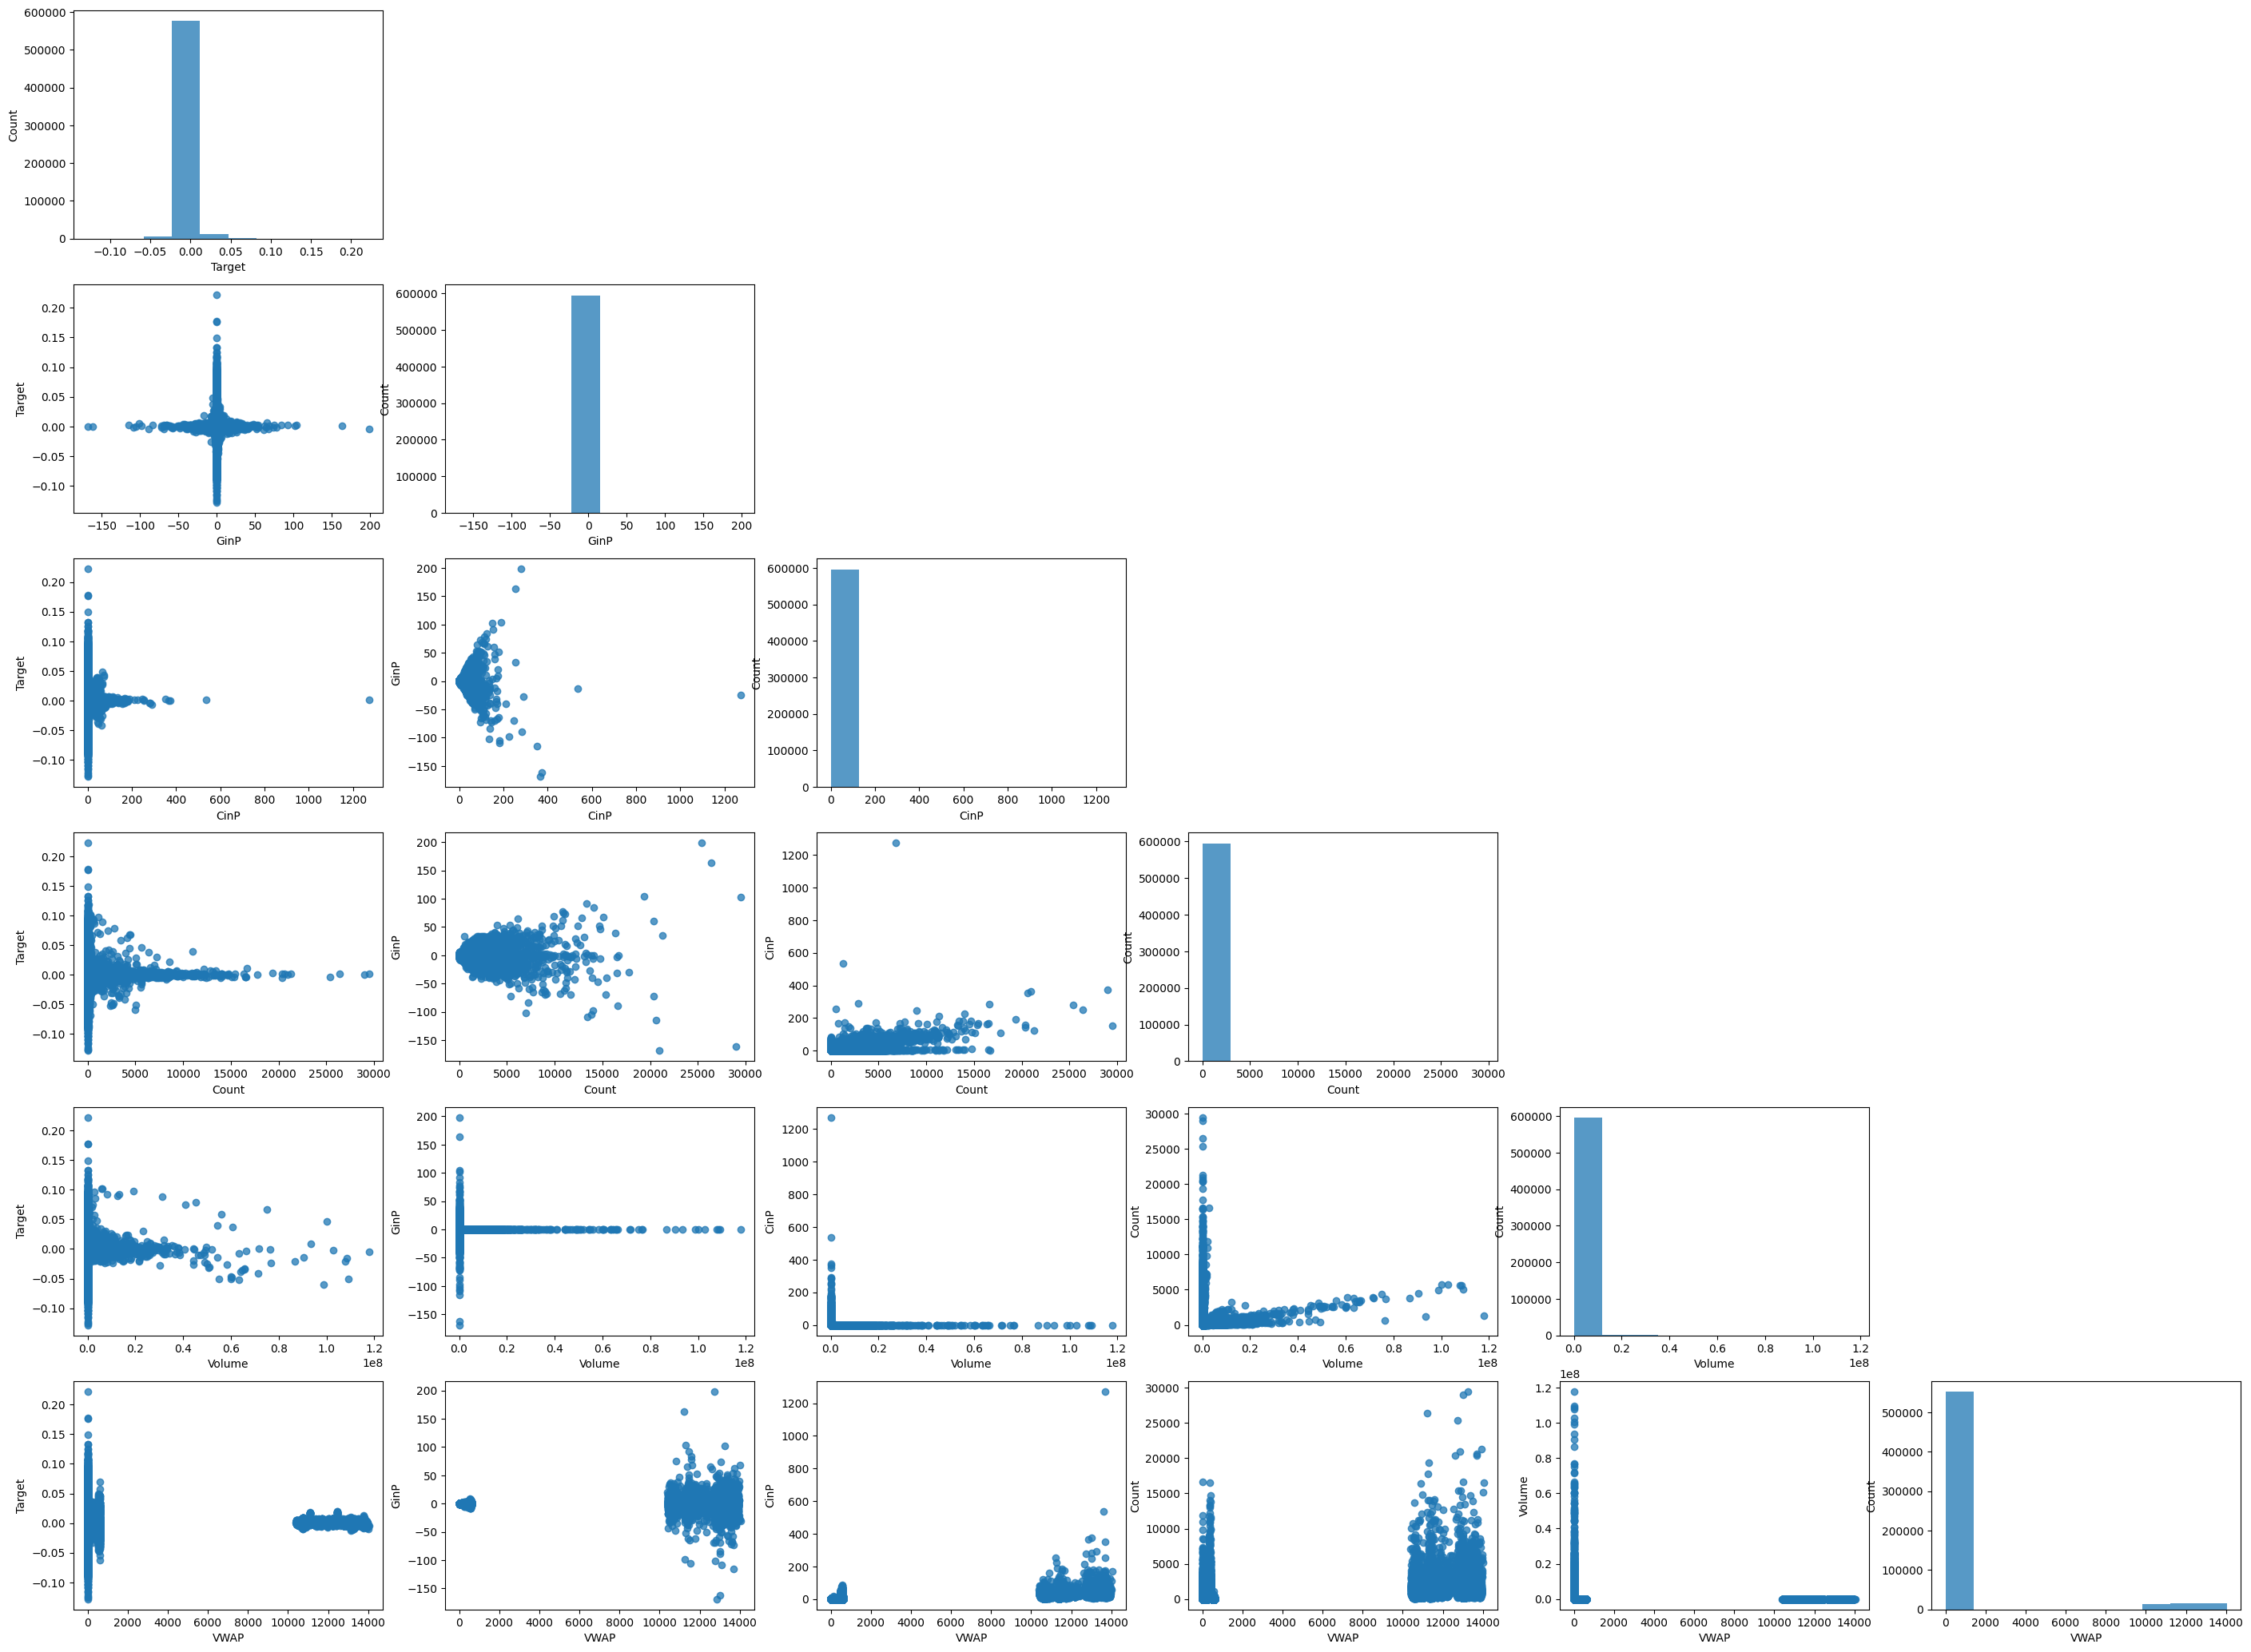

In [27]:
variables = ['Target', 'GinP', 'CinP', 'Count', 'Volume', 'VWAP', ]
scatterplotmatrix(
    crypto_base_model_df[variables].values,
    names=variables,
    figsize=(35,26), 
    alpha=.75,
);

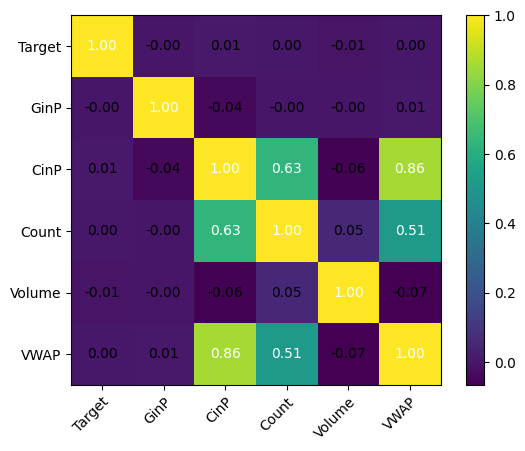

In [28]:
cm = crypto_base_model_df[variables].corr().values

hm = heatmap(
    cm,
    row_names=variables,
    column_names=variables)

### Create One-Hot Encodings for Asset_Name

In [29]:
## create one-hot-encodings ##
##############################

def create_one_hot_asset_id(input_df):
    
    # create data frame with just target columns
    my_df = input_df[['Asset_Name']]
    # turn asset id to one-hot
    my_df = pd.get_dummies(
        my_df['Asset_Name'],
        drop_first = False
    ) 
    return my_df

In [30]:
# join new one-hot assets with base model
dummies =  create_one_hot_asset_id(crypto_df)
crypto_base_model_df = pd.concat([crypto_base_model_df, dummies], axis=1)
# keep the old Asset_ID for later function calls and delete it after all transformation complete

In [31]:
crypto_base_model_df.head(1)

,Target,timestamp,Asset_ID,GinP,CinP,Count,Volume,VWAP,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON
16382768,0.0029,2020-10-01 00:01:00,3,0.0001,0.0002,101.0000,275978.1361,0.1015,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Break down timestamp into month, day, hour, and minute, also create a 'UniqueHourPerAsset' string ID for grouby function to create 1hour history info per asset to feed to RNN model

In [32]:
crypto_base_model_df['Date'] = crypto_base_model_df['timestamp'].dt.date
crypto_base_model_df['Time'] = crypto_base_model_df['timestamp'].dt.time
crypto_base_model_df['Month'] = crypto_base_model_df['timestamp'].dt.month
crypto_base_model_df['Day'] = crypto_base_model_df['timestamp'].dt.day
crypto_base_model_df['Hour'] = crypto_base_model_df['timestamp'].dt.hour
crypto_base_model_df['Minute'] = crypto_base_model_df['timestamp'].dt.minute

crypto_base_model_df['UniqueHourPerAsset'] = crypto_base_model_df['Asset_ID'].astype(str) + ',' + crypto_base_model_df['timestamp'].dt.strftime("%Y-%m-%d,%H")


# drop the timestamp column
#crypto_base_model_df.drop("timestamp", axis=1, inplace=True)

temp_cols=crypto_base_model_df.columns.tolist() # all columns
#temp_cols

target_column = 'Target'
unique_id = 'UniqueHourPerAsset'
temp_cols.remove(target_column)
temp_cols.remove(unique_id)
temp_cols.remove('timestamp')
temp_cols.remove('Date')
temp_cols.remove('Time')
temp_cols.remove('Month')
temp_cols.remove('Day')
temp_cols.remove('Hour')
temp_cols.remove('Minute')
temp_cols.remove('Asset_ID')
feature_columns = temp_cols
new_cols = [unique_id]+['Month']+['Day']+['Hour']+['Minute']+feature_columns+[target_column]
#new_cols
crypto_base_model_df=crypto_base_model_df[new_cols]

# keep the old timestamp for later function calls and delete it after all transformation complete

In [33]:
print(crypto_base_model_df['Day'].min())

1


In [34]:
print(crypto_base_model_df['Day'].max())

31


In [35]:
crypto_base_model_df.columns

Index(['UniqueHourPerAsset', 'Month', 'Day', 'Hour', 'Minute', 'GinP', 'CinP',
       'Count', 'Volume', 'VWAP', 'Binance Coin', 'Bitcoin', 'Bitcoin Cash',
       'Cardano', 'Dogecoin', 'EOS.IO', 'Ethereum', 'Ethereum Classic', 'IOTA',
       'Litecoin', 'Maker', 'Monero', 'Stellar', 'TRON', 'Target'],
      dtype='object')

In [36]:
crypto_base_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 596088 entries, 16382768 to 16978855
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   UniqueHourPerAsset  596088 non-null  object 
 1   Month               596088 non-null  int32  
 2   Day                 596088 non-null  int32  
 3   Hour                596088 non-null  int32  
 4   Minute              596088 non-null  int32  
 5   GinP                596088 non-null  float64
 6   CinP                596088 non-null  float64
 7   Count               596088 non-null  float64
 8   Volume              596088 non-null  float64
 9   VWAP                596088 non-null  float64
 10  Binance Coin        596088 non-null  bool   
 11  Bitcoin             596088 non-null  bool   
 12  Bitcoin Cash        596088 non-null  bool   
 13  Cardano             596088 non-null  bool   
 14  Dogecoin            596088 non-null  bool   
 15  EOS.IO              596088 non

In [37]:
crypto_base_model_df

,UniqueHourPerAsset,Month,Day,Hour,Minute,GinP,CinP,Count,Volume,VWAP,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON,Target
16382768,"3,2020-10-01,00",10,1,0,1,0.0001,0.0002,101.0000,275978.1361,0.1015,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0029
16382780,"11,2020-10-01,00",10,1,0,1,0.0825,0.3500,35.0000,59.4327,108.7008,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-0.0008
16382779,"12,2020-10-01,00",10,1,0,1,0.0001,0.0002,151.0000,258970.1328,0.0750,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.0033
16382778,"13,2020-10-01,00",10,1,0,1,0.0000,0.0001,82.0000,1511164.7801,0.0262,False,False,False,False,False,False,False,False,False,False,False,False,False,True,-0.0007
16382776,"9,2020-10-01,00",10,1,0,1,0.0124,0.0800,74.0000,1101.5174,46.3107,False,False,False,False,False,False,False,False,False,True,False,False,False,False,-0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16978843,"2,2020-10-31,23",10,31,23,59,-0.0200,0.3200,29.0000,31.5002,262.1631,False,False,True,False,False,False,False,False,False,False,False,False,False,False,-0.0015
16978842,"3,2020-10-31,23",10,31,23,59,-0.0000,0.0001,6.0000,1384.4982,0.0930,False,False,False,True,False,False,False,False,False,False,False,False,False,False,-0.0001
16978854,"12,2020-10-31,23",10,31,23,59,0.0000,0.0001,19.0000,11953.4901,0.0777,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.0010
16978847,"5,2020-10-31,23",10,31,23,59,-0.0004,0.0012,52.0000,1815.8840,2.5284,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0.0003


## Bucketize data to feed 1-hour history and split into Train, Validation, and Test to RNN-LSTM Model

In [38]:
df = crypto_base_model_df.groupby('UniqueHourPerAsset').agg(list)
df

,Month,Day,Hour,Minute,GinP,CinP,Count,Volume,VWAP,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON,Target
UniqueHourPerAsset,,,,,,,,,,,,,,,,,,,,,,,,
"0,2020-10-01,00","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.032399999999999096, 0.047699999999998965, -...","[0.08129999999999882, 0.0727000000000011, 0.03...","[414.0, 374.0, 244.0, 239.0, 134.0, 211.0, 190...","[10266.986999999996, 4402.242000000002, 3341.2...","[29.294034856311814, 29.310141330349392, 29.33...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[-0.0058542715962233, -0.0036839200444737, -0...."
"0,2020-10-01,01","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.007699999999999818, -0.013399999999997192, ...","[0.08569999999999922, 0.03999999999999915, 0.0...","[240.0, 104.0, 346.0, 346.0, 391.0, 160.0, 221...","[2081.0599999999968, 1208.7310000000011, 4334....","[29.062566005257, 29.03522392525712, 28.986092...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[0.0004292942035143, 0.0015828176183392, 0.002..."
"0,2020-10-01,02","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.026700000000001722, 0.005649999999999267, -...","[0.05760000000000076, 0.06290000000000262, 0.0...","[575.0, 364.0, 178.0, 108.0, 104.0, 79.0, 60.0...","[6491.554000000001, 6963.065400000005, 4051.20...","[29.09623621226895, 29.103819976751428, 29.111...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[0.0017758252071646, 0.00129

In [39]:
## Padding zeros for the missing minute
## each interation is one hour of history of a single asset
pad_value = 0
for index, row in df.iterrows():
    if (len(row['Minute']) != 60):
        for pos in range(60):
            if pos == 0:
                month_ = row['Month'][0]
                day_ = row['Day'][0]
                hour_ = row['Hour'][0]
                coin1 = row['Binance Coin'][0]
                coin2 = row['Bitcoin'][0]
                coin3 = row['Bitcoin Cash'][0]
                coin4 = row['Cardano'][0]
                coin5 = row['Dogecoin'][0]
                coin6 = row['EOS.IO'][0]
                coin7 = row['Ethereum'][0]
                coin8 = row['Ethereum Classic'][0]
                coin9 = row['IOTA'][0]
                coin10 = row['Litecoin'][0]
                coin11 = row['Maker'][0]
                coin12 = row['Monero'][0]
                coin13 = row['Stellar'][0]
                coin14 = row['TRON'][0]
            if pos >= len(row['Minute']):
                row['Month'].append(month_)
                row['Day'].append(day_)
                row['Hour'].append(hour_)                
                row['Binance Coin'].append(coin1)
                row['Bitcoin'].append(coin2)
                row['Bitcoin Cash'].append(coin3)
                row['Cardano'].append(coin4) 
                row['Dogecoin'].append(coin5)
                row['EOS.IO'].append(coin6)
                row['Ethereum'].append(coin7)
                row['Ethereum Classic'].append(coin8)
                row['IOTA'].append(coin9)
                row['Litecoin'].append(coin10)
                row['Maker'].append(coin11)
                row['Monero'].append(coin12)
                row['Stellar'].append(coin13)
                row['TRON'].append(coin14)
                row['Minute'].append(pos)  # missing minute is the position
                # the following should pad zero
                row['GinP'].append(pad_value)
                row['CinP'].append(pad_value)
                row['Count'].append(pad_value)
                row['Volume'].append(pad_value)
                row['VWAP'].append(pad_value)
                row['Target'].append(pad_value)
            elif row['Minute'][pos] != pos:  # missing this minute and need to pad
                row['Month'].insert(pos, month_)
                row['Day'].insert(pos, day_)
                row['Hour'].insert(pos, hour_)
                row['Binance Coin'].insert(pos, coin1)
                row['Bitcoin'].insert(pos, coin2)
                row['Bitcoin Cash'].insert(pos, coin3)
                row['Cardano'].insert(pos, coin4) 
                row['Dogecoin'].insert(pos, coin5)
                row['EOS.IO'].insert(pos, coin6)
                row['Ethereum'].insert(pos, coin7)
                row['Ethereum Classic'].insert(pos, coin8)
                row['IOTA'].insert(pos, coin9)
                row['Litecoin'].insert(pos, coin10)
                row['Maker'].insert(pos, coin11)
                row['Monero'].insert(pos, coin12)
                row['Stellar'].insert(pos, coin13)
                row['TRON'].insert(pos, coin14)
                row['Minute'].insert(pos, pos)  # missing minute is the position
                # the following should pad zero
                row['GinP'].insert(pos, pad_value)
                row['CinP'].insert(pos, pad_value)
                row['Count'].insert(pos, pad_value)
                row['Volume'].insert(pos, pad_value)
                row['VWAP'].insert(pos, pad_value)
                row['Target'].insert(pos, pad_value)
                
                

In [40]:
df.index

Index(['0,2020-10-01,00', '0,2020-10-01,01', '0,2020-10-01,02',
       '0,2020-10-01,03', '0,2020-10-01,04', '0,2020-10-01,05',
       '0,2020-10-01,06', '0,2020-10-01,07', '0,2020-10-01,08',
       '0,2020-10-01,09',
       ...
       '9,2020-10-31,14', '9,2020-10-31,15', '9,2020-10-31,16',
       '9,2020-10-31,17', '9,2020-10-31,18', '9,2020-10-31,19',
       '9,2020-10-31,20', '9,2020-10-31,21', '9,2020-10-31,22',
       '9,2020-10-31,23'],
      dtype='object', name='UniqueHourPerAsset', length=10415)

In [41]:
X_train = np.empty([8333, 60, 23])
Y_train = np.empty([8333, 60, 1])
X_val   = np.empty([1041, 60, 23])
Y_val   = np.empty([1041, 60, 1])
X_test  = np.empty([1041, 60, 23])
Y_test  = np.empty([1041, 60, 1])

In [42]:
## turn dataframe into train, val and test with 80,10,10 ratios
train_idx,val_idx,test_idx=0,0,0
split_idx=0
for index, row in df.iterrows():
    if split_idx in [0,1,2,3,4,5,6,7]:
        X_train[train_idx] = np.array([row['Month'],row['Day'],row['Hour'],row['Minute'],row['GinP'],row['CinP'],row['Count'],row['Volume'],row['VWAP'],row['Binance Coin'],row['Bitcoin'],row['Bitcoin Cash'],
        row['Cardano'],row['Dogecoin'],row['EOS.IO'],row['Ethereum'],row['Ethereum Classic'],row['IOTA'],row['Litecoin'],row['Maker'],row['Monero'],row['Stellar'],row['TRON']]).T
        Y_train[train_idx] = np.array([row['Target']]).T
        # print(f'train_idx = {train_idx}')
        train_idx += 1
    elif split_idx in [8]:
        X_test[test_idx] = np.array([row['Month'],row['Day'],row['Hour'],row['Minute'],row['GinP'],row['CinP'],row['Count'],row['Volume'],row['VWAP'],row['Binance Coin'],row['Bitcoin'],row['Bitcoin Cash'],
        row['Cardano'],row['Dogecoin'],row['EOS.IO'],row['Ethereum'],row['Ethereum Classic'],row['IOTA'],row['Litecoin'],row['Maker'],row['Monero'],row['Stellar'],row['TRON']]).T
        Y_test[test_idx] = np.array([row['Target']]).T
        # print(f'test_idx = {test_idx}')
        test_idx += 1
    else:
        X_val[val_idx] = np.array([row['Month'],row['Day'],row['Hour'],row['Minute'],row['GinP'],row['CinP'],row['Count'],row['Volume'],row['VWAP'],row['Binance Coin'],row['Bitcoin'],row['Bitcoin Cash'],
        row['Cardano'],row['Dogecoin'],row['EOS.IO'],row['Ethereum'],row['Ethereum Classic'],row['IOTA'],row['Litecoin'],row['Maker'],row['Monero'],row['Stellar'],row['TRON']]).T
        Y_val[val_idx] = np.array([row['Target']]).T
        # print(f'val_idx = {val_idx}')
        val_idx += 1
    split_idx += 1
    if split_idx==10: split_idx=0
print(f'train_idx = {train_idx}, test_idx = {test_idx}, val_idx = {val_idx}')
    

train_idx = 8333, test_idx = 1041, val_idx = 1041


Print out dimension of all input data

In [43]:
X_train.shape

(8333, 60, 23)

In [44]:
Y_train.shape

(8333, 60, 1)

In [45]:
X_val.shape

(1041, 60, 23)

In [46]:
Y_val.shape

(1041, 60, 1)

In [47]:
X_test.shape

(1041, 60, 23)

In [48]:
Y_test.shape

(1041, 60, 1)

## Build RNN-LSTM prediction model

In [49]:
def build_lstm_model(len_features):
    """
    Return a simple Keras model with a single LSTM layer, dropout later, 
    and then dense prediction layer.
    
    Args:
    lstm_hidden_units (int): units in the LSTM layer    
    
    Returns:
    model_lstm (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    model_lstm = None
    
    # instanntiate model
    model_lstm = tf.keras.Sequential()
    
    # add layers
    model_lstm.add(Bidirectional(LSTM(
        units=200,
        #recurrent_dropout=0.4,
        #use_bias=True,
        go_backwards=True,
        return_sequences=True,
        name='LSTM1'), name='bidir-LSTM1'))    
    
    model_lstm.add(Dropout(
        rate=0.5,
        name='Dropout1'
    ))
    
    # add layers
    model_lstm.add(Dense(
        units=64,
        activation='relu',
        name='Dense1'
    ))
    
    
    model_lstm.add(Dense(
        units=1,
        #activation='sigmoid',
        name='Dense2'))
    
    model_lstm.build(input_shape=(None, None, len_features))

    
    model_lstm.summary()

    # END CODE #
    return model_lstm

In [50]:
features_len = 23
model_lstm = build_lstm_model(features_len)
output = model_lstm(X_train)
#output

2023-04-15 23:06:14.545235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:06:14.546164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 23:06:14.546838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidir-LSTM1 (Bidirectional)  (None, None, 400)        358400    
                                                                 
 Dropout1 (Dropout)          (None, None, 400)         0         
                                                                 
 Dense1 (Dense)              (None, None, 64)          25664     
                                                                 
 Dense2 (Dense)              (None, None, 1)           65        
                                                                 
Total params: 384,129
Trainable params: 384,129
Non-trainable params: 0
_________________________________________________________________


2023-04-15 23:06:15.083709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 23:06:15.084848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 23:06:15.085938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [51]:
# Look at 1-hour output
output[0]

<tf.Tensor: shape=(60, 1), dtype=float64, numpy=
array([[-1.12011989],
       [-1.22623171],
       [-1.26975148],
       [-1.23798774],
       [-1.23223499],
       [-1.2274521 ],
       [-1.26517875],
       [-1.05516864],
       [-1.24277706],
       [-1.27002999],
       [-1.2436485 ],
       [-1.22278306],
       [-1.26480039],
       [-1.26725625],
       [-1.24485558],
       [-1.24727082],
       [-1.20436343],
       [-1.30270893],
       [-1.24681159],
       [-1.24365772],
       [-1.2430282 ],
       [-1.23187891],
       [-1.26748399],
       [-1.24410916],
       [-1.24372902],
       [-1.25434234],
       [-1.18368505],
       [-1.24374216],
       [-1.21692189],
       [-1.23972063],
       [-1.24351026],
       [-1.23680105],
       [-1.24631204],
       [-1.26659687],
       [-1.29306531],
       [-1.25244182],
       [-1.25173765],
       [-1.26103632],
       [-1.26234338],
       [-1.24077169],
       [-1.25787148],
       [-1.26339629],
       [-1.24523236],
     

In [52]:
# define metrics
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.MeanSquaredError(name='mse'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [53]:
## Choose an optimizer
optimizer_choice = 'Adam'

if (optimizer_choice == 'SGE'):
    optimizer = tf.keras.optimizers.legacy.SGD(
        learning_rate=0.01,
        momentum=0.0,
        nesterov=False,
        name='SGD'
    )
elif (optimizer_choice == 'Adam'):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.003, # 1e-3
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        weight_decay=0.003,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name='Adam'
    )
elif (optimizer_choice == 'AdamW'):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.001,
        weight_decay=0.004,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name='AdamW'
    )
else:
    print("ERROR: No Optimizer is picked")

In [54]:
## compile and train:

model_lstm.compile(
    #optimizer=tf.keras.optimizers.Adam(1e-3),
    optimizer=optimizer,
    #loss=tf.keras.losses.BinaryCrossentropy(),
    loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM),
    metrics=METRICS
)

# Train model
history = model_lstm.fit(x=X_train,
                         y=Y_train,
                         validation_data=(X_val,Y_val),
                         # validation_split=0.1, # set 10% of train data for validation
                         epochs=15,
                         verbose=1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                         #callbacks=[tensorboard_callback]
)

Epoch 1/15


2023-04-15 23:06:17.364719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-04-15 23:06:17.401518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 23:06:17.402792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

261/261 [==============================] - ETA: 0s - loss: 50.1088 - mse: 0.0261

2023-04-15 23:06:28.660265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-04-15 23:06:28.694084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 23:06:28.695216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

261/261 [==============================] - 12s 36ms/step - loss: 50.1088 - mse: 0.0261 - val_loss: 0.0851 - val_mse: 4.4381e-05
Epoch 2/15
261/261 [==============================] - 9s 34ms/step - loss: 0.1323 - mse: 6.8925e-05 - val_loss: 0.0851 - val_mse: 4.4376e-05
Epoch 3/15
261/261 [==============================] - 9s 34ms/step - loss: 0.1101 - mse: 5.7399e-05 - val_loss: 0.0851 - val_mse: 4.4378e-05
Epoch 4/15
261/261 [==============================] - 9s 34ms/step - loss: 0.1006 - mse: 5.2435e-05 - val_loss: 0.0851 - val_mse: 4.4377e-05
Epoch 5/15
261/261 [==============================] - 9s 34ms/step - loss: 0.0976 - mse: 5.0930e-05 - val_loss: 0.0851 - val_mse: 4.4383e-05
Epoch 6/15
261/261 [==============================] - 9s 34ms/step - loss: 0.0935 - mse: 4.8715e-05 - val_loss: 0.0851 - val_mse: 4.4377e-05
Epoch 7/15
261/261 [==============================] - 9s 34ms/step - loss: 0.0920 - mse: 4.7980e-05 - val_loss: 0.0851 - val_mse: 4.4395e-05
Epoch 8/15
261/261 [======

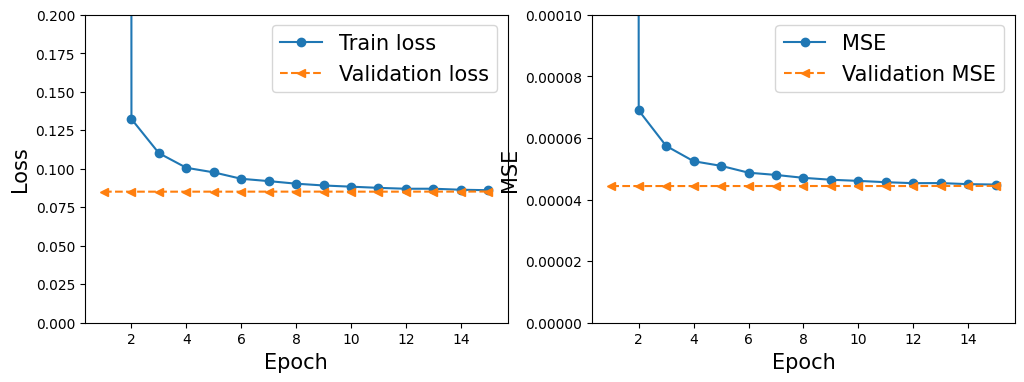

In [55]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_ylim(0,0.20)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['mse'], '-o', label='MSE')
ax.plot(x_arr, hist['val_mse'], '--<', label='Validation MSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('MSE', size=15)
ax.set_ylim(0,0.0001)

plt.show()


## Evaluate the Model with Testset

In [56]:
# Test model
history = model_lstm.evaluate(x=X_test,
                              y=Y_test,
                              verbose=1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                              #callbacks=[tensorboard_callback]
)

33/33 [==============================] - 1s 15ms/step - loss: 0.0845 - mse: 4.4059e-05


## Final Scores
### <span style="color:chocolate">loss: 0.0845 - mse: 4.4059e-05</span>

### Delete the Original Dataframe

In [57]:
# delete original dataframe to free up memory
del crypto_df